In [15]:
import time
from nldg.utils import *
from nldg.rf import MaggingRF
from adaXT.random_forest import RandomForest
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from experiments.bcd_test_runtime import assign_quadrant

NAME_RF = "WORME-RF"

## WORME Random Forest

In [2]:
dtr = gen_data_v6(n=1000, noise_std=0.5, setting=2)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)
n_estimators = 50
min_samples_leaf = 30
random_state = 42

In [3]:
rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
)
rf.fit(Xtr, Ytr)
fitted_rf = rf.predict(Xtr)
preds_rf = rf.predict(Xtr_sorted)
max_mse(Ytr, fitted_rf, Etr, verbose=True)

Environment 0 MSE: 27.232536315149154
Environment 1 MSE: 10.374557076632346
Environment 2 MSE: 3.8926755345048556


np.float64(27.232536315149154)

In [4]:
rf.modify_predictions_trees(Etr)  # n_jobs=2 to parallelize
fitted_minmax = rf.predict(Xtr)
preds_minmax = rf.predict(Xtr_sorted)
max_mse(Ytr, fitted_minmax, Etr, verbose=True)

Environment 0 MSE: 18.013170836763724
Environment 1 MSE: 17.58426938521204
Environment 2 MSE: 8.604819264011887


np.float64(18.013170836763724)

In [5]:
rf_magging = MaggingRF(
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    random_state=random_state,
    backend='adaXT',
)
fitted_magging, preds_magging = rf_magging.fit_predict_magging(Xtr, Ytr, Etr, Xtr_sorted)
wmag = rf_magging.get_weights()
max_mse(Ytr, fitted_magging, Etr, verbose=True)

Environment 0 MSE: 36.62227887913162
Environment 1 MSE: 5.908213075569638
Environment 2 MSE: 1.5728738119291998


np.float64(36.62227887913162)

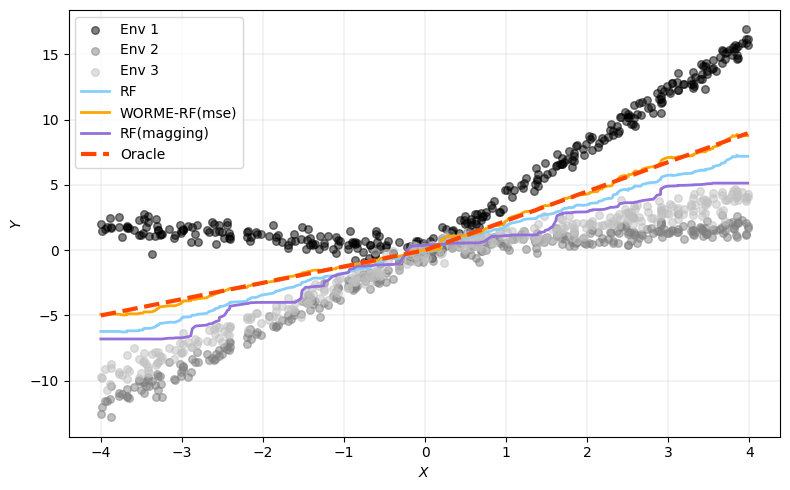

In [6]:
dtr["X_sorted"] = Xtr_sorted
dtr["fitted_rf"] = preds_rf
dtr["fitted_minmax"] = preds_minmax
dtr["fitted_magging"] = preds_magging
plot_dtr(dtr, optfun=4, saveplot=True, nameplot="setting9_intro")

## CVXPY vs. Extragradient

In [8]:
# Fit RF again to start with the same predictions
rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
)
rf.fit(Xtr, Ytr)
rf.modify_predictions_trees(Etr, opt_method="extragradient")  # n_jobs=2 to parallelize
fitted_minmax_xtrgrd = rf.predict(Xtr)
preds_minmax_xtrgrd = rf.predict(Xtr_sorted)
max_mse(Ytr, fitted_minmax_xtrgrd, Etr, verbose=True)

Environment 0 MSE: 17.95916862144212
Environment 1 MSE: 17.671324035436747
Environment 2 MSE: 8.690178171792274


np.float64(17.95916862144212)

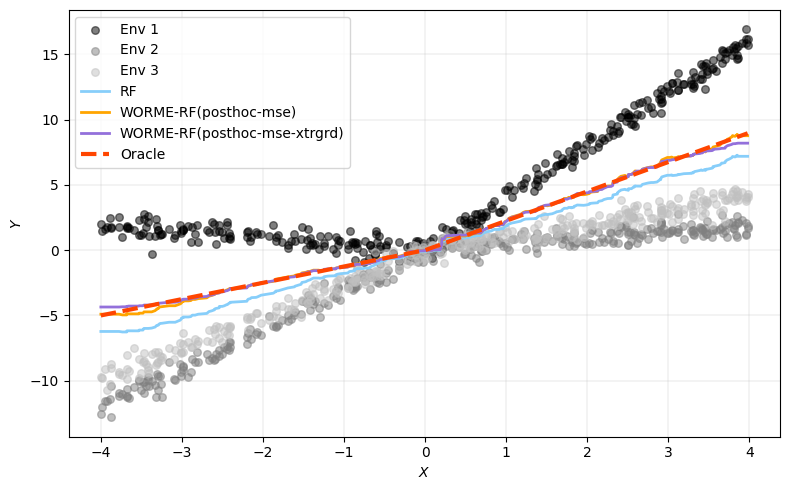

In [9]:
dtr["X_sorted"] = Xtr_sorted
dtr["fitted_rf"] = preds_rf
dtr["fitted_minmax"] = preds_minmax
dtr["fitted_minmax_xtrgrd"] = preds_minmax_xtrgrd
dtr = dtr.drop(columns=["fitted_magging"])
plot_dtr(dtr, optfun=4, saveplot=True, nameplot="setting9_xtrgrd")

In [10]:
dtr = gen_data_v7(n=1500)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)
n_estimators = 50
min_samples_leaf = 30
random_state = 42

In [11]:
rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
)
rf.fit(Xtr, Ytr)
fitted_rf = rf.predict(Xtr)
preds_rf = rf.predict(Xtr_sorted)
max_mse(Ytr, fitted_rf, Etr, verbose=True)

Environment 0 MSE: 0.6491252306459793
Environment 1 MSE: 0.9944854316638767
Environment 2 MSE: 0.17889046608446182


np.float64(0.9944854316638767)

In [12]:
rf.modify_predictions_trees(Etr)
fitted_rf_2 = rf.predict(Xtr)
preds_rf_2 = rf.predict(Xtr_sorted)
max_mse(Ytr, fitted_rf_2, Etr, verbose=True)

Environment 0 MSE: 0.7794879916148291
Environment 1 MSE: 0.791872266753139
Environment 2 MSE: 0.3396310277810282


np.float64(0.791872266753139)

In [13]:
rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
)
rf.fit(Xtr, Ytr)
rf.modify_predictions_trees(Etr, opt_method="extragradient")
fitted_rf_3 = rf.predict(Xtr)
preds_rf_3 = rf.predict(Xtr_sorted)
max_mse(Ytr, fitted_rf_3, Etr, verbose=True)

Environment 0 MSE: 0.7786859729245341
Environment 1 MSE: 0.7918215786580122
Environment 2 MSE: 0.3387936879749758


np.float64(0.7918215786580122)

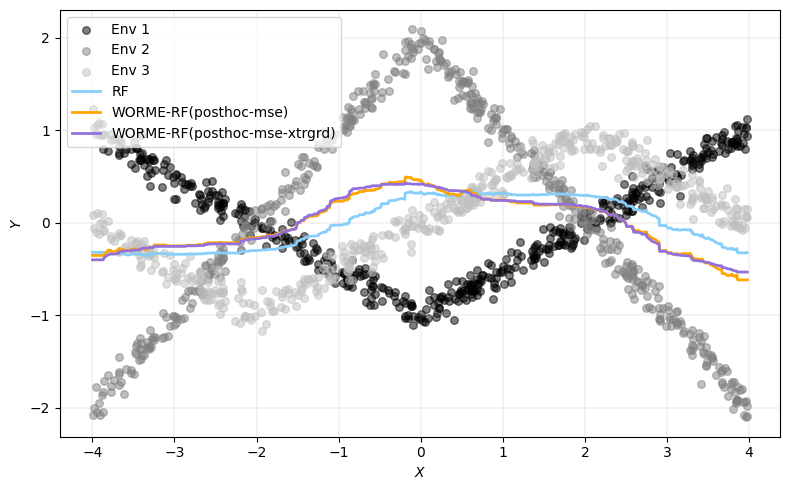

In [14]:
dtr["X_sorted"] = Xtr_sorted
dtr["fitted_rf"] = preds_rf
dtr["fitted_minmax"] = preds_rf_2
dtr["fitted_minmax_xtrgrd"] = preds_rf_3
plot_dtr(dtr, saveplot=True, nameplot="setting6_xtrgrd")

## BCD vs. non-BCD

In [21]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
Z = X[["Latitude", "Longitude"]]
X = X.drop(["Latitude", "Longitude"], axis=1)
env = assign_quadrant(Z)
n_estimators = 25
min_samples_leaf = 30
random_state = 42

In [22]:
rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
)
rf.fit(X, y)

In [23]:
fitted_rf = rf.predict(X)
max_mse(y, fitted_rf, env, verbose=True)

Environment 0 MSE: 0.48655113551891316
Environment 1 MSE: 0.3763981201336164
Environment 2 MSE: 0.3912163609381252
Environment 3 MSE: 0.405833155424949


np.float64(0.48655113551891316)

In [24]:
mean_squared_error(y, fitted_rf)

0.38480567847408337

In [25]:
start = time.time()
rf.modify_predictions_trees(env, bcd=True, patience=1, block_size=15)
end = time.time()
print("Runtime BCD:", end-start)

Runtime BCD: 22.97212243080139


In [26]:
fitted_minimax_bcd = rf.predict(X)
max_mse(y, fitted_minimax_bcd, env, verbose=True)

Environment 0 MSE: 0.42784861647925554
Environment 1 MSE: 0.3844080076078675
Environment 2 MSE: 0.392960958593621
Environment 3 MSE: 0.4183931982202505


np.float64(0.42784861647925554)

In [27]:
mean_squared_error(y, fitted_minimax_bcd)

0.3901846580451994

In [28]:
rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
)
rf.fit(X, y)
start = time.time()
rf.modify_predictions_trees(env)
end = time.time()
print("Runtime non-BCD:", end-start)

Runtime non-BCD: 29.894315242767334


In [29]:
fitted_minimax_nonbcd = rf.predict(X)
max_mse(y, fitted_minimax_nonbcd, env, verbose=True)

Environment 0 MSE: 0.4305618887372771
Environment 1 MSE: 0.3849660460051351
Environment 2 MSE: 0.3873507468408596
Environment 3 MSE: 0.4122442078878542


np.float64(0.4305618887372771)

In [30]:
mean_squared_error(y, fitted_minimax_nonbcd)

0.3879304940917196

Note that if the block size is larger than the number of leaves, the result of the block-coordinate descent (BCD) algorithm is the same as the non-BCD version.

## Different Objectives

In [17]:
demean_setting = 1
dtr = gen_data_v5(n_samples=1000, adv_fraction=0.1, noise_var_env2=2, setting=2)

Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr_orig = np.array(dtr['Y'])
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)
n_estimators = 50
random_state = 42
min_samples_leaf = 30

if demean_setting == 1:
    Ytr = Ytr_orig
elif demean_setting == 2:
    Ytr = np.zeros_like(Ytr_orig)
    for env in np.unique(Etr):
        idx = Etr == env
        Ytr[idx] = Ytr_orig[idx] - np.mean(Ytr_orig[idx])

# Fit standard RF for each environment separately.
# This is used for the regret
sols_erm = np.zeros(Etr.shape[0])
sols_erm_trees = np.zeros((n_estimators, Etr.shape[0]))
for env in np.unique(Etr):
    mask = Etr == env
    X_e = Xtr[mask]
    Y_e = Ytr[mask]
    rf_e = RandomForest(
        "Regression",
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        seed=random_state
    )
    rf_e.fit(X_e, Y_e)
    fitted_e = rf_e.predict(X_e)
    sols_erm[mask] = fitted_e
    for i in range(n_estimators):
        fitted_e_tree = rf_e.trees[i].predict(X_e)
        sols_erm_trees[i, mask] = fitted_e_tree

#### Standard RF

In [18]:
rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
)
rf.fit(Xtr, Ytr)
fitted_rf = rf.predict(Xtr)
preds_rf = rf.predict(Xtr_sorted)

mse_rf, _ = max_mse(Ytr, fitted_rf, Etr, ret_ind=True)
rw_rf, _ = min_reward(Ytr, fitted_rf, Etr, ret_ind=True)
regret_rf, _ = max_regret(Ytr, fitted_rf, sols_erm, Etr, ret_ind=True)

#### MSE

In [19]:
rf.modify_predictions_trees(Etr)  # modify solver with, e.g., solver="ECOS"
fitted_mse = rf.predict(Xtr)
preds_mse = rf.predict(Xtr_sorted)

mse_mse, _ = max_mse(Ytr, fitted_mse, Etr, ret_ind=True)
rw_mse, _ = min_reward(Ytr, fitted_mse, Etr, ret_ind=True)
regret_mse, _ = max_regret(Ytr, fitted_mse, sols_erm, Etr, ret_ind=True)

#### Reward

In [20]:
rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state
)
rf.fit(Xtr, Ytr)
rf.modify_predictions_trees(Etr, method="reward")
fitted_rw = rf.predict(Xtr)
preds_rw = rf.predict(Xtr_sorted)

mse_rw, _ = max_mse(Ytr, fitted_rw, Etr, ret_ind=True)
rw_rw, _ = min_reward(Ytr, fitted_rw, Etr, ret_ind=True)
regret_rw, _ = max_regret(Ytr, fitted_rw, sols_erm, Etr, ret_ind=True)

#### Regret

In [21]:
rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state
)
rf.fit(Xtr, Ytr)
rf.modify_predictions_trees(
    Etr,
    method="regret",
    sols_erm=sols_erm,
    sols_erm_trees=sols_erm_trees
)
fitted_regret = rf.predict(Xtr)
preds_regret = rf.predict(Xtr_sorted)

mse_regret, _ = max_mse(Ytr, fitted_regret, Etr, ret_ind=True)
rw_regret, _ = min_reward(Ytr, fitted_regret, Etr, ret_ind=True)
regret_regret, _ = max_regret(Ytr, fitted_regret, sols_erm, Etr, ret_ind=True)

#### RF - magging

In [22]:
rf_magging = MaggingRF(
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    random_state=random_state,
    backend='adaXT',
)
fitted_magging, preds_magging = rf_magging.fit_predict_magging(Xtr, Ytr, Etr, Xtr_sorted)
wmag = rf_magging.get_weights()

mse_magging, _ = max_mse(Ytr, fitted_magging, Etr, ret_ind=True)
rw_magging, _ = min_reward(Ytr, fitted_magging, Etr, ret_ind=True)
regret_magging, _ = max_regret(Ytr, fitted_magging, sols_erm, Etr, ret_ind=True)

#### Comparison

In [23]:
cols = pd.MultiIndex.from_product(
    [["MSE", "Reward", "Regret"], ["0", "1"]],
    names=["Metric", "Env"]
)
data = [
    [round(float(x), 3) for x in mse_rf + rw_rf + regret_rf],
    [round(float(x), 3) for x in mse_mse + rw_mse + regret_mse],
    [round(float(x), 3) for x in mse_rw + rw_rw + regret_rw],
    [round(float(x), 3) for x in mse_regret + rw_regret + regret_regret],
    [round(float(x), 3) for x in mse_magging + rw_magging + regret_magging],
]
df = pd.DataFrame(
    data,
    index=
    [
        "RF",
        f"{NAME_RF}(posthoc-mse)",
        f"{NAME_RF}(posthoc-nrw)",
        f"{NAME_RF}(posthoc-reg)",
        "RF(magging)"
    ],
    columns=cols)
print(df)

Metric                   MSE         Reward         Regret        
Env                        0       1      0       1      0       1
RF                     0.407  17.513  1.211  13.681  0.154  12.925
WORME-RF(posthoc-mse)  5.825   6.739 -4.207  24.455  5.572   2.151
WORME-RF(posthoc-nrw)  0.267  20.749  1.351  10.445  0.014  16.162
WORME-RF(posthoc-reg)  3.374   9.071 -1.757  22.123  3.121   4.483
RF(magging)            0.253  20.874  1.365  10.320  0.000  16.286


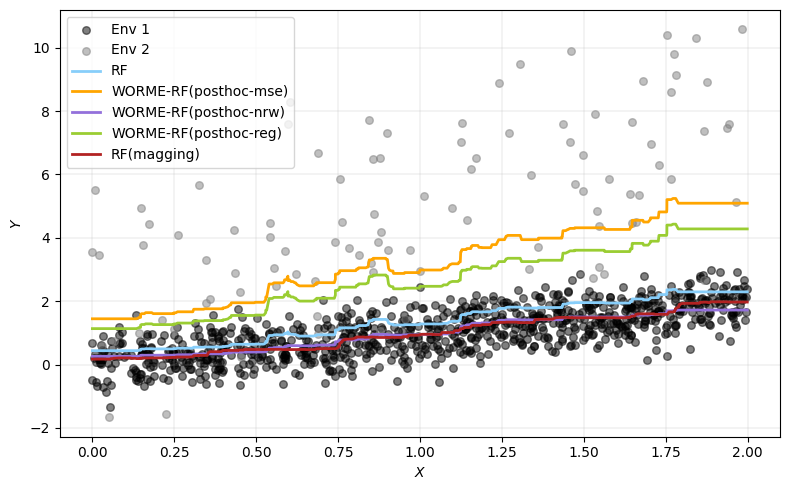

In [24]:
dtr["X_sorted"] = Xtr_sorted
dtr["fitted_rf"] = preds_rf
dtr["fitted_mse"] = preds_mse
dtr["fitted_nrw"] = preds_rw
dtr["fitted_regret"] = preds_regret
dtr["fitted_magging"] = preds_magging
dtr["Y"] = Ytr

plot_dtr(dtr, obj_comparison=True, saveplot=True, nameplot="setting8_objectives")